# MNIST - Loading, Training and Evaluation

This notebook covers the main stages in Deep Learning, acting as an introduction to both the PyTorch platform as well as some impotant steps when loading data, defining a model, training and evaluation.

In [175]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import time

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../../util')
import vcpi_util

print(torch.__version__)

2.2.1+cu118


In [176]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [177]:
transform = transforms.Compose([transforms.ToTensor()])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [178]:
print(train_set.classes)
print(train_set.data.shape)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([60000, 28, 28])


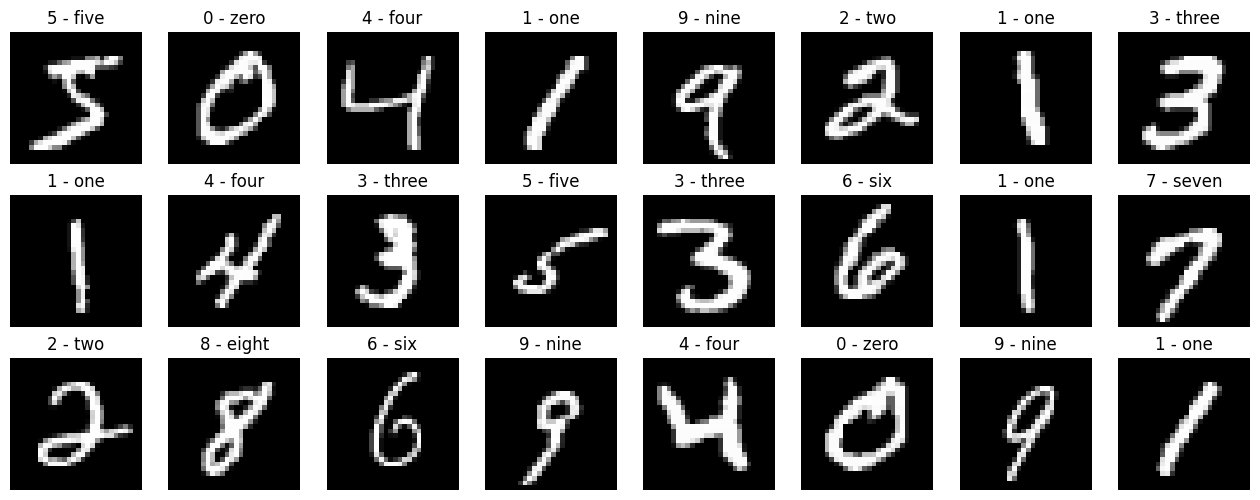

<Figure size 640x480 with 0 Axes>

In [179]:
vcpi_util.show_loaded_images(3,8, train_set, train_set.classes)

In [180]:
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [181]:
print(len(train_loader.dataset))
print(len(train_loader))

60000
469


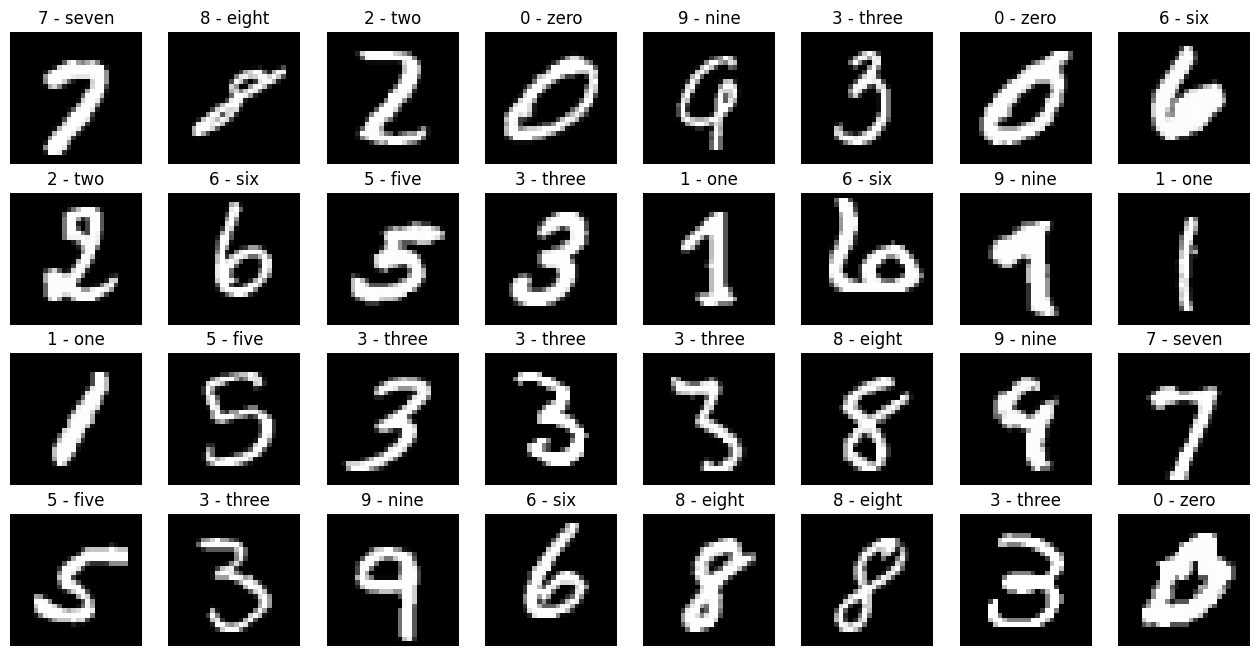

<Figure size 640x480 with 0 Axes>

In [182]:
images, targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images, targets, train_set.classes)

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


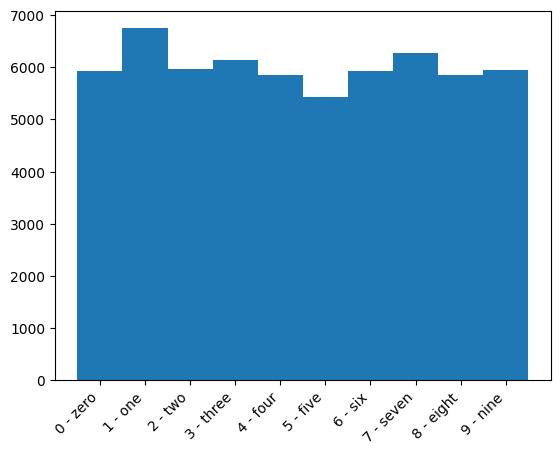

In [183]:
vcpi_util.show_histogram(train_set.targets, train_set.classes)

In [184]:
class FullyConnected_I(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 28 * 28 = 784
        self.fc1 = torch.nn.Linear(28*28, 64)
        self.relu = torch.nn.ReLU()
                                    # 10 classes
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x= self.fc2(x)
        return x
    
model = FullyConnected_I()
model.to(device)
print(model)

FullyConnected_I(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [185]:
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FullyConnected_I                         [128, 10]                 --
├─Linear: 1-1                            [128, 64]                 50,240
├─ReLU: 1-2                              [128, 64]                 --
├─Linear: 1-3                            [128, 10]                 650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 6.51
Input size (MB): 0.40
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.68

In [186]:
images, targets = next(iter(train_loader))

logits = model(images.to(device))

print(logits)

predictions = torch.nn.functional.softmax(logits, dim=1)

tensor([[-0.0484,  0.0308, -0.1133,  ...,  0.0753, -0.0283,  0.0581],
        [-0.0166,  0.0829,  0.0090,  ...,  0.1624, -0.0645,  0.0486],
        [-0.0935,  0.0871, -0.0509,  ...,  0.0802, -0.1253,  0.1552],
        ...,
        [-0.0448,  0.0932, -0.0204,  ...,  0.1391, -0.1398,  0.1211],
        [-0.1668,  0.0421,  0.0429,  ...,  0.1240, -0.0131,  0.1419],
        [-0.0847,  0.0579,  0.1065,  ...,  0.2291,  0.0622,  0.1509]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [187]:
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    
    for images, targets in data_loader:
        output = model(images.to(device))
        # os targets que vem neste dataset não são vetores, são o número da classe
        # converter os valores no número da classe
        # (probabilidade máxima, elemento máximo)
        _, preds = torch.max(output, dim=1)
        
        correct += (preds.cpu() == targets).sum()
    return (correct / len(data_loader.dataset)).item()

In [188]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

In [189]:
def train(model, data_loader, epochs):
    model.train()
    
    history = {}
    history['accuracy'] = []
    history['loss'] = []
    
    for epoch in range(epochs):
        
        start_time = time.time()
        correct = 0
        running_loss = 0
        for i, (images, targets) in enumerate(data_loader,0):
            # fazer sempre estes dois passos
            images = images.to(device)
            targets = targets.to(device)
            
            output = model(images)
            
            # array com 128 elementos, cada elemento com 10 valores: um para cada classe
            # queremos saber a classe com valor máximo
            _, preds = torch.max(output, dim=1)
            
            loss = loss_fn(output, targets)
            optimizer.zero_grad() # inicializar os gradientes a zero
            loss.backward()
            
            optimizer.step() #atualizar os gradientes
            
            running_loss += loss
            correct += (preds == targets).sum()
            
        accuracy = 100*correct / len(train_set)
        stop_time = time.time()
        print(f"Epoch: {epoch}; Acc: {accuracy}; Loss: {running_loss:0.4f}; Time: {stop_time-start_time}")
        history['accuracy'].append(accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())
    return history
        

In [190]:
history = train(model, train_loader, 10)

Epoch: 0; Acc: 87.80999755859375; Loss: 223.9291; Time: 7.645603656768799
Epoch: 1; Acc: 93.03166961669922; Loss: 114.4063; Time: 7.784750699996948
Epoch: 2; Acc: 94.60833740234375; Loss: 87.7348; Time: 7.358172416687012
Epoch: 3; Acc: 95.77333068847656; Loss: 70.1403; Time: 7.211291790008545
Epoch: 4; Acc: 96.43333435058594; Loss: 58.3112; Time: 7.188301086425781
Epoch: 5; Acc: 96.95999908447266; Loss: 49.8735; Time: 7.181189775466919
Epoch: 6; Acc: 97.28666687011719; Loss: 43.2048; Time: 7.212326765060425
Epoch: 7; Acc: 97.7066650390625; Loss: 37.8912; Time: 7.446110963821411
Epoch: 8; Acc: 97.91500091552734; Loss: 33.6183; Time: 10.843106269836426
Epoch: 9; Acc: 98.1300048828125; Loss: 30.2092; Time: 10.894630670547485


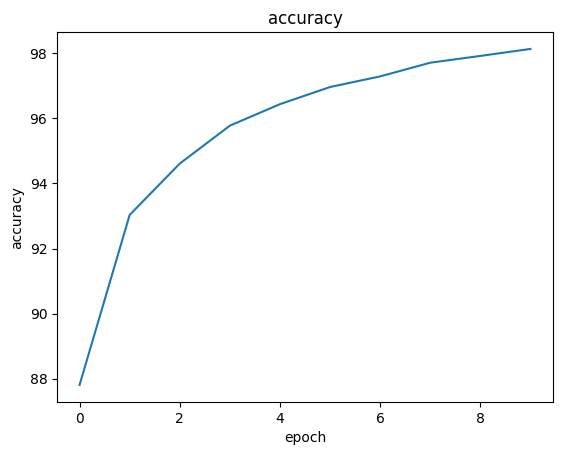

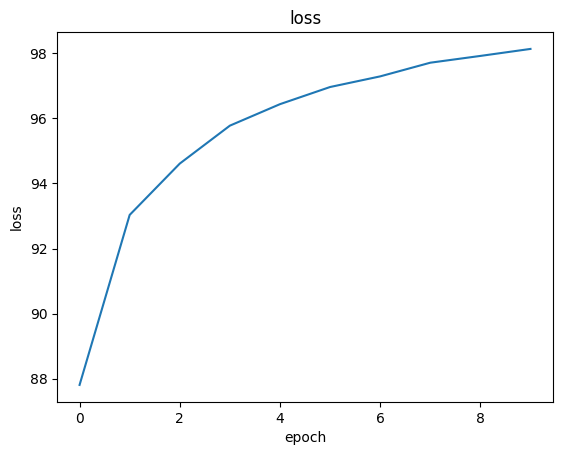

In [191]:
vcpi_util.show_history(history)

In [192]:
evaluate(model, test_loader)

0.9728999733924866

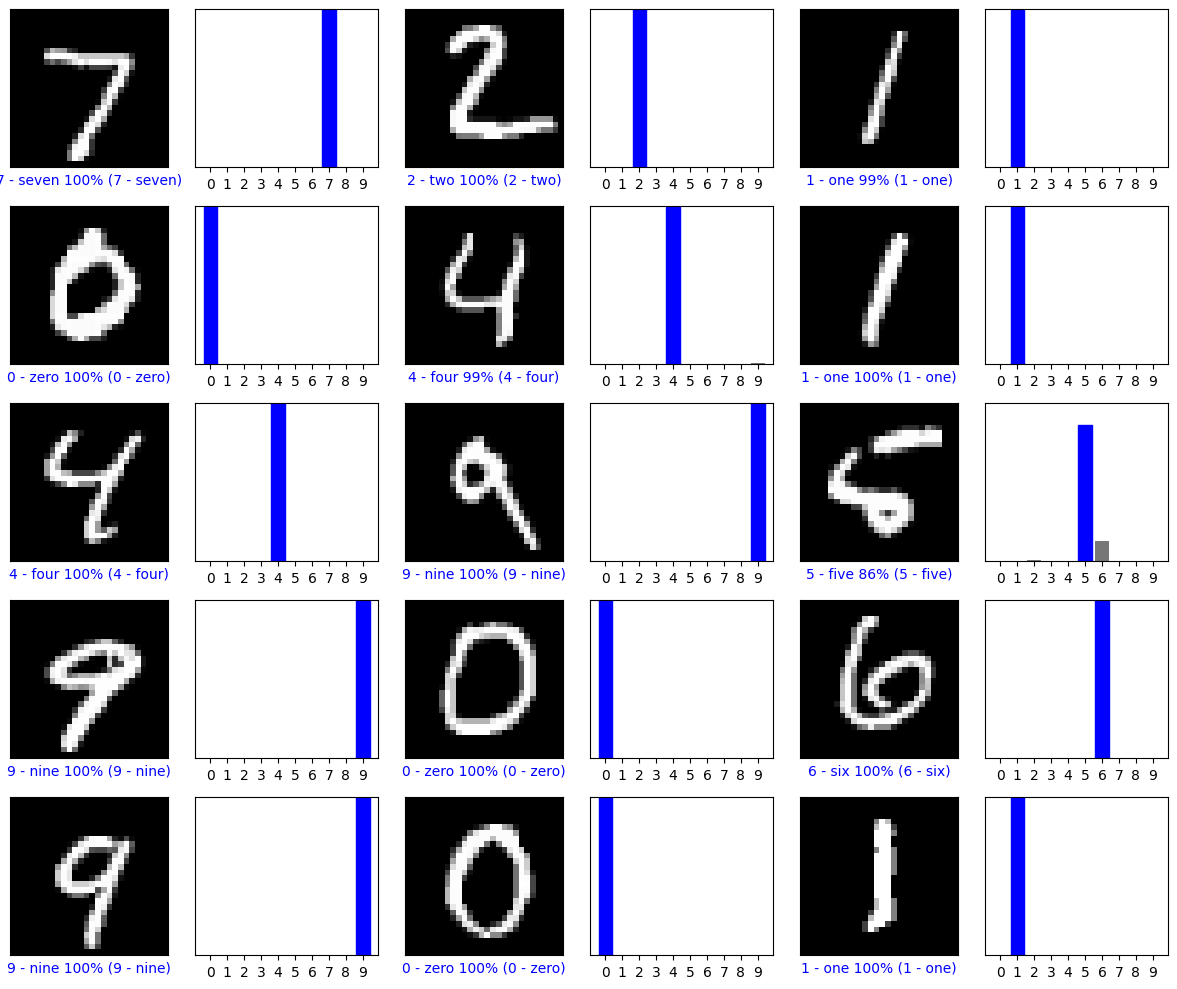

In [193]:
images, targets = next(iter(test_loader))
logits = model(images.to(device))

preds = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
vcpi_util.plot_predictions(images, preds, targets, train_set.classes, 5, 3)

In [204]:
k = 0
iters = 0

wrong_preds = []
ground_truth = []
imgs = torch.Tensor(15,1,28,28)

iterator = iter(test_loader)
max_iters = test_set.__len__() / BATCH_SIZE

while k < 10 and iters < max_iters:
    
    images, targets = next(iterator)
    logits = model(images.to(device))
    
    preds = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
    
    for i in range(len(preds)):
        
        if np.argmax(preds[i]) != targets[i] and k < 25:
            wrong_preds.append(preds[i])
            ground_truth.append(targets[i])
            imgs[k, :,:,:] = images[i]
            k += 1
            
    iters += 1

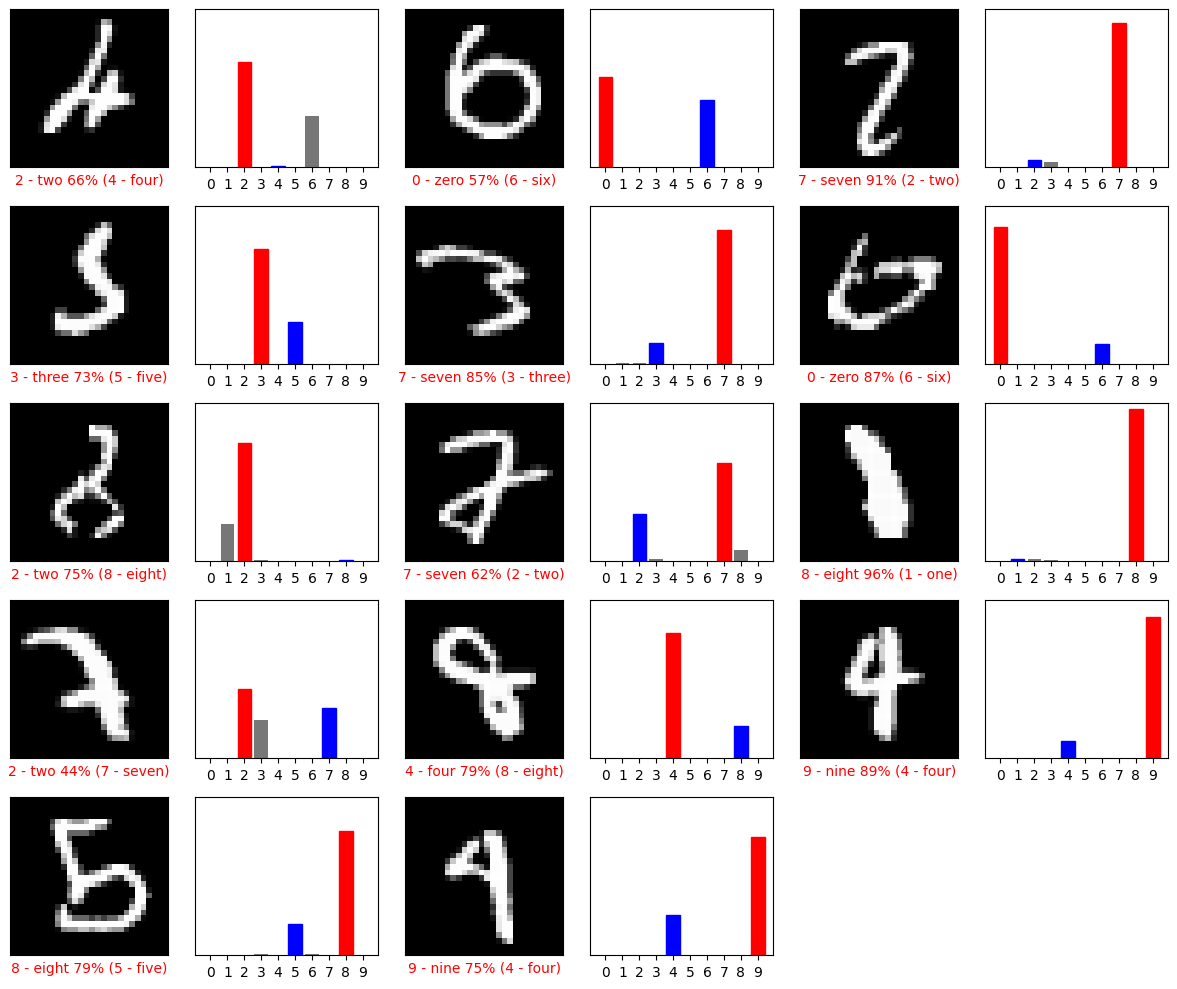

In [205]:
vcpi_util.plot_predictions(imgs, wrong_preds, ground_truth, train_set.classes, 5, 3)

In [206]:
preds = []
ground_truth = []
for images, targets in test_loader:
    
    logits = model(images.to(device))
    preds_batch = [np.argmax(x) for x in logits.cpu().detach().numpy()]
    
    preds.extend(preds_batch)
    ground_truth.extend(targets.numpy())

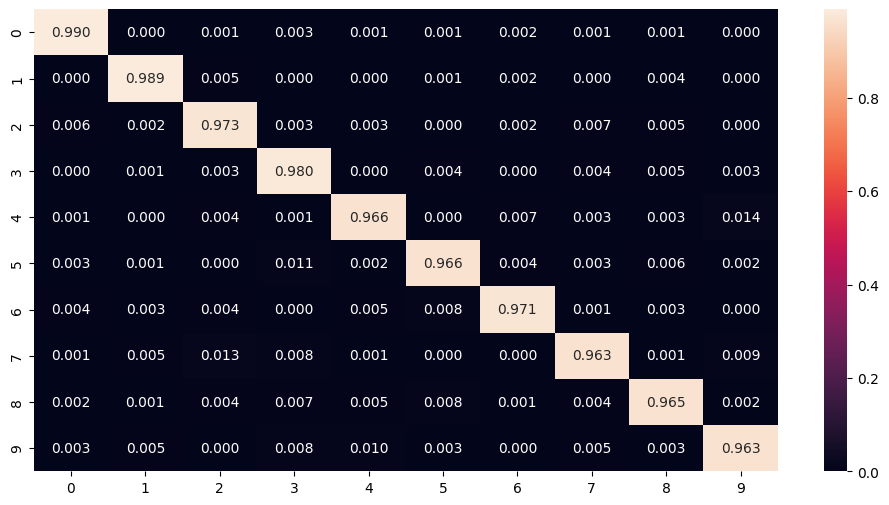

In [207]:
vcpi_util.show_confusion_matrix(ground_truth, preds, len(train_set.classes))

In [208]:
torch.save({
    'epoch': 10,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'history':history
}, 'model.pt')

In [209]:
retrieved_model = FullyConnected_I()
retrieved_optimizer = torch.optim.Adam(retrieved_model.parameters())

retrieved = torch.load('model.pt')

In [210]:
retrieved_model.load_state_dict(retrieved['model'])
retrieved_model.to(device)
retrieved_optimizer.load_state_dict(retrieved['optimizer'])

In [211]:
model_scripted = torch.jit.script(model)
model_scripted.save('model_scripted.pt')

scripted_model = torch.jit.load('model_scripted.pt')
evaluated = evaluate(scripted_model, test_loader)